In [1]:
import numpy as np 
import pandas as pd 
import os

path="/kaggle/input/face-expression-recognition-dataset"

for dirpath, dirnames, filenames in os.walk("/kaggle/input/face-expression-recognition-dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/kaggle/input/face-expression-recognition-dataset'.
There are 3 directories and 0 images in '/kaggle/input/face-expression-recognition-dataset/images'.
There are 7 directories and 0 images in '/kaggle/input/face-expression-recognition-dataset/images/validation'.
There are 0 directories and 797 images in '/kaggle/input/face-expression-recognition-dataset/images/validation/surprise'.
There are 0 directories and 1018 images in '/kaggle/input/face-expression-recognition-dataset/images/validation/fear'.
There are 0 directories and 960 images in '/kaggle/input/face-expression-recognition-dataset/images/validation/angry'.
There are 0 directories and 1216 images in '/kaggle/input/face-expression-recognition-dataset/images/validation/neutral'.
There are 0 directories and 1139 images in '/kaggle/input/face-expression-recognition-dataset/images/validation/sad'.
There are 0 directories and 111 images in '/kaggle/input/face-expression-recognition-dataset/ima

validation dataset :
surprise 797
fear 1018
angry 960
neutral 1216
sad 1139
disgust 111
happy 1825

train dataset :
surprise 3205
fear 4103
angry 3993
neutral 4982
sad 4938
disgust 436
happy 7164

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt

In [3]:
train_data_dir='/kaggle/input/face-expression-recognition-dataset/images/train'
validation_data_dir='/kaggle/input/face-expression-recognition-dataset/images/images/validation'

In [4]:
#for train data set
train_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=30,
     shear_range=0.3,
     zoom_range=0.3,
     horizontal_flip=True,
     fill_mode='nearest')

In [5]:
#for validation dataset
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
#image height
IMG_HEIGHT=48
#image width 
IMG_WIDTH = 48
#batch size
batch_size=32
seed = 42

In [7]:
# create training sets
train_generator = train_datagen.flow_from_directory(
     train_data_dir,
     color_mode='grayscale',
     target_size=(IMG_HEIGHT, IMG_WIDTH),
     batch_size=batch_size,
     class_mode='categorical',
     shuffle=True,
     seed=seed)

Found 28821 images belonging to 7 classes.


In [8]:
#create Validation sets
validation_generator = validation_datagen.flow_from_directory(
       validation_data_dir,
       color_mode='grayscale',
       target_size=(IMG_HEIGHT, IMG_WIDTH),
       batch_size=batch_size,
       class_mode='categorical',
       shuffle=True,
       seed=seed)

Found 7066 images belonging to 7 classes.


In [9]:
#emotions list
class_labels=['angry','disgust', 'fear', 'happy','neutral','sad','surprise']

In [10]:
img, label = train_generator.__next__()

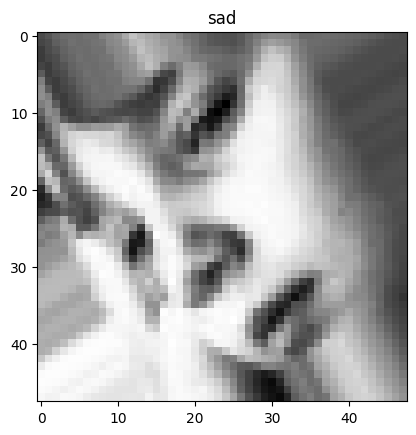

In [11]:
#import random module
import random

#create a number 
i=random.randint(0, (img.shape[0])-1)
#get image
image = img[i]
#get image label
labl = class_labels[label[i].argmax()]

#ploting
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [12]:
model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(7, activation='softmax'))

In [13]:
#get model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [14]:
#compile the model
model.compile(optimizer = Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# determine early stoping mechanism
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# Instantiate ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             mode='min',
                             verbose=1)

# reduce learning rate mechanism
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

# make callback as a list
callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [16]:
#epoch size
epochs=50
num_train_imgs=28821
num_test_imgs=7066

# fit model
history=model.fit(train_generator,
                steps_per_epoch=num_train_imgs//train_generator.batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=num_test_imgs//validation_generator.batch_size,
                callbacks=callbacks_list)

Epoch 1/50
900/900 [==============================] - ETA: 0s - loss: 1.8818 - accuracy: 0.2505
Epoch 1: val_loss improved from inf to 1.78210, saving model to best_model.h5
900/900 [==============================] - 704s 778ms/step - loss: 1.8818 - accuracy: 0.2505 - val_loss: 1.7821 - val_accuracy: 0.2952 - lr: 0.0010
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


900/900 [==============================] - ETA: 0s - loss: 1.6371 - accuracy: 0.3563
Epoch 2: val_loss improved from 1.78210 to 1.53984, saving model to best_model.h5
900/900 [==============================] - 675s 750ms/step - loss: 1.6371 - accuracy: 0.3563 - val_loss: 1.5398 - val_accuracy: 0.3947 - lr: 0.0010
Epoch 3/50
900/900 [==============================] - ETA: 0s - loss: 1.4907 - accuracy: 0.4220
Epoch 3: val_loss improved from 1.53984 to 1.50527, saving model to best_model.h5
900/900 [==============================] - 670s 744ms/step - loss: 1.4907 - accuracy: 0.4220 - val_loss: 1.5053 - val_accuracy: 0.4187 - lr: 0.0010
Epoch 4/50
900/900 [==============================] - ETA: 0s - loss: 1.4115 - accuracy: 0.4558
Epoch 4: val_loss improved from 1.50527 to 1.32903, saving model to best_model.h5
900/900 [==============================] - 664s 737ms/step - loss: 1.4115 - accuracy: 0.4558 - val_loss: 1.3290 - val_accuracy: 0.4888 - lr: 0.0010
Epoch 5/50
900/900 [=============

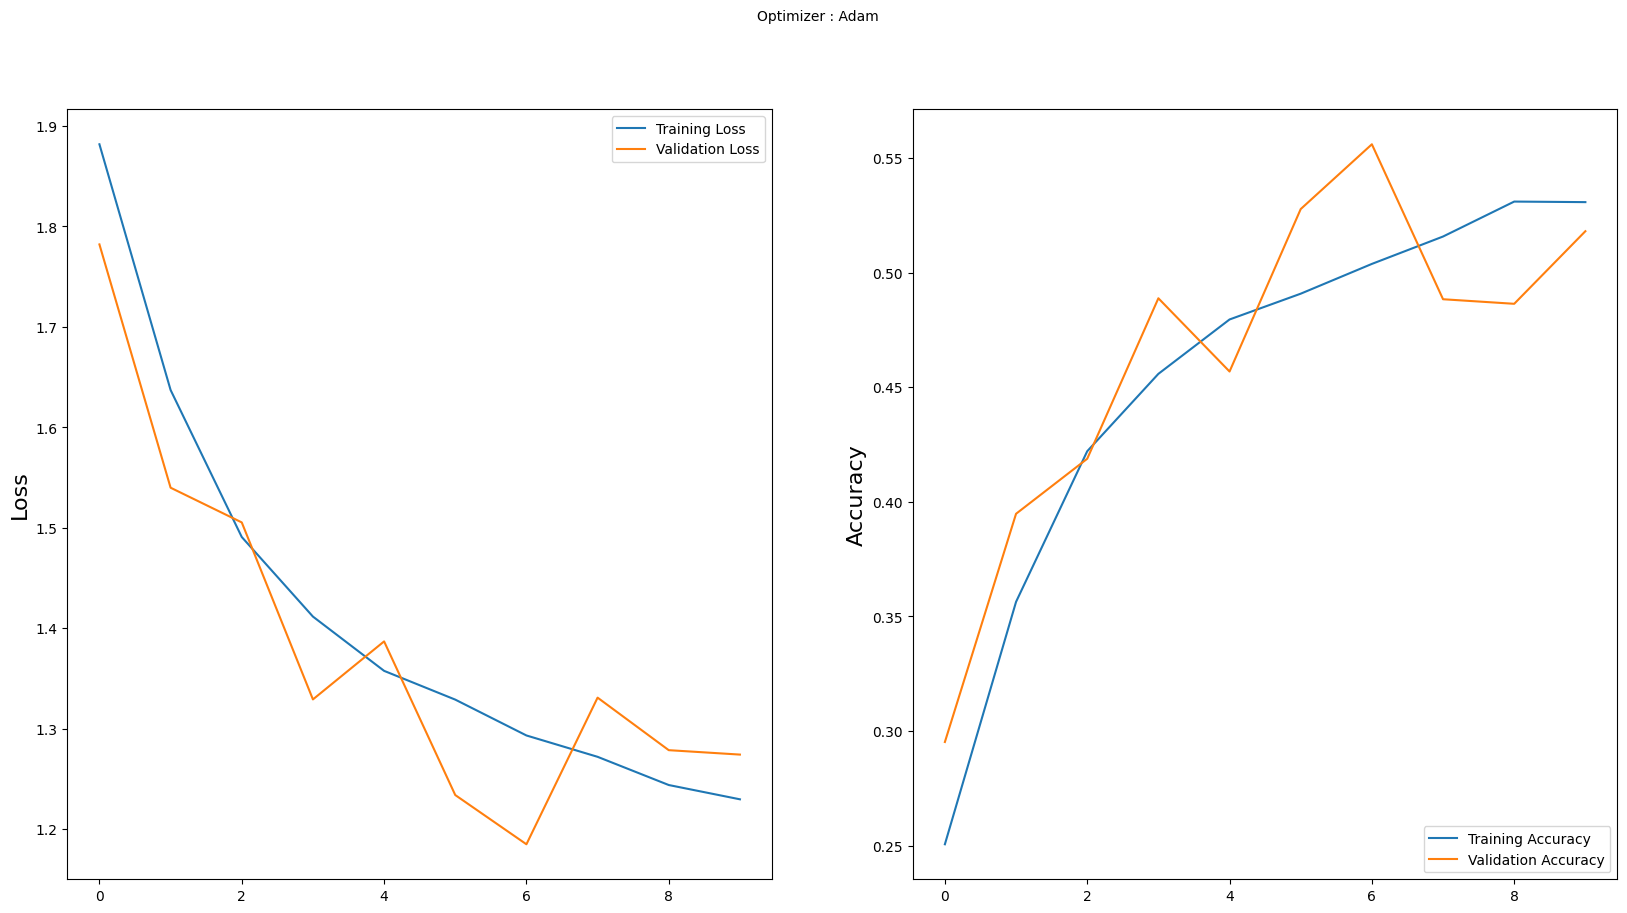

In [17]:
#figure size
plt.figure(figsize=(20,10))
#make subplot
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
#get training loss
plt.plot(history.history['loss'], label='Training Loss')
#get validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [18]:
# Get one random images and predict it
#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
#prediction thist test images
predictions=model.predict(test_img)

1/1 [==============================] - 0s 430ms/step


In [19]:
# Using np.argmax and convert predictions
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

In [20]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

Accuracy =  0.5625


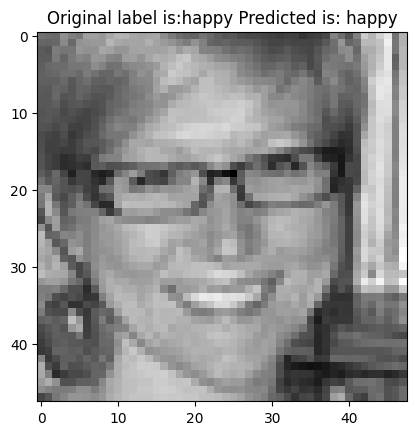

In [21]:
class_labels=['angry','disgust', 'fear', 'happy','neutral','sad','surprise']

#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()